In [1]:
import pandas as pd 
import numpy as np
import xarray as xr
import ee
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, TimeDistributed
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from keras import optimizers

In [3]:
#Initialize and Authenticate the gee client
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AVHEtk7__aey3iIb2Lq_bJbSHUdIEf4tf4HNLbgYNAim47WZQrm691Dzvto

Successfully saved authorization token.


In [4]:
# Define the latitude and longitude of the point
lat = 24.3357
lon = -0.7778

# Create a point geometry
point = ee.Geometry.Point(lon, lat)
#CNN-LSTM
#Define the number of years of data to use for training
train_years = 12

#Define the number of days of data to use for each time step
time_steps = 30

#Define the number of time steps to uses for each training sequence
sequence_length = 30

# Define the number of filters and kernel size for the CNN layer
num_filters = 64
kernel_size = 3

# Define the number of LSTM units for the LSTM layer
num_lstm_units = 128

# Define the number of epochs and batch size for training
num_epochs = 100
batch_size = 32

# Define the time range for the data
start_date = ee.Date('2004-01-01')
end_date = ee.Date('2008-12-31')

# Filter the image collection
precip = ee.ImageCollection('  ')

# Filter the image collection by date and select the 'precipitationCal' band
daily_precip = precip.filterDate(start_date, end_date)\
                    .select('precipitationCal')                    
#Reduce the image collection to a single image at the given loacation and time
precip_image = daily_precip.filterBounds(point)

# Extract the precipitation value at the give region
precip_data = precip_image.getRegion(point, scale = 0.1).getInfo()

#Convert the data into a dataframe
columns = ['time', 'latitude', 'longitude','quality','precipitationCal']
precip_df = pd.DataFrame(precip_data[1:], columns=columns)
precip_df.set_index('time', inplace = True)

# Convert the index to  datetime object
precip_df.index = pd.to_datetime(precip_df.index, format='%Y%m%d%H%M%S')

# Resample the data to daily frequency
precip_df_daily = precip_df.resample('D').sum()

In [5]:
precip_df_daily

,latitude,longitude,quality,precipitationCal
time,,,,
2004-01-01,-37.334378,1168.113608,51501960000000,0.000000
2004-01-02,-37.334378,1168.113608,51506107200000,0.000000
2004-01-03,-37.334378,1168.113608,51510254400000,0.000000
2004-01-04,-37.334378,1168.113608,51514401600000,0.000000
2004-01-05,-37.334378,1168.113608,51518548800000,0.000000
...,...,...,...,...
2008-12-26,-37.334378,1168.113608,59054011200000,0.000000
2008-12-27,-37.334378,1168.113608,59058158400000,0.008815
2008-12-28,-37.334378,1168.113608,59062305600000,0.106295


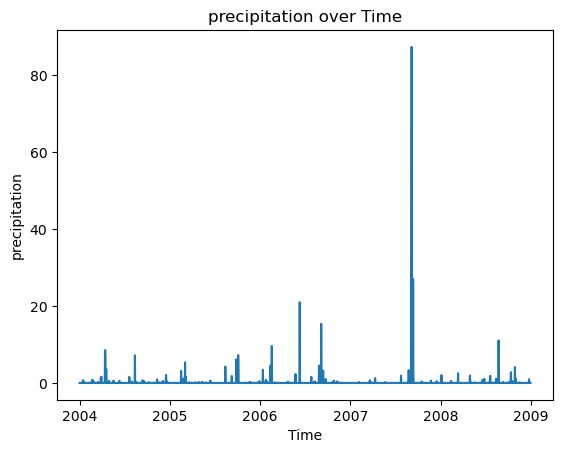

In [6]:
# Visualize the dataset for check of stationarity
plt.plot(precip_df_daily.index,precip_df_daily['precipitationCal'])
plt.title('precipitation over Time')
plt.xlabel('Time')
plt.ylabel('precipitation')
plt.show()

In [7]:
#Precipitation batch 2
precip_daily2=precip.filterDate(ee.Date('2009-01-01'),ee.Date('2013-12-31')).select('precipitationCal').filterBounds(point)

# Extract the precipitation value at the give region
precip_data2 = precip_daily2.getRegion(point, scale = 0.1).getInfo()

#Convert the data into a dataframe
columns = ['time', 'latitude', 'longitude','quality','precipitationCal']
precip_df2 = pd.DataFrame(precip_data2[1:], columns=columns)
precip_df2.set_index('time', inplace = True)

# Convert the index to  datetime object
precip_df2.index = pd.to_datetime(precip_df2.index, format='%Y%m%d%H%M%S')

# Resample the data to daily frequency
precip_df_daily2 = precip_df2.resample('D').sum()


<Axes: xlabel='time'>

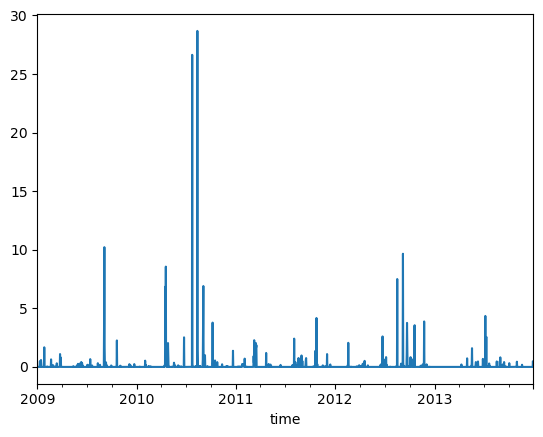

In [8]:
precip_df_daily2['precipitationCal'].plot()

In [9]:
#Precipitation batch 3
precip_daily3=precip.filterDate(ee.Date('2014-01-01'),ee.Date('2018-12-31')).select('precipitationCal').filterBounds(point)

# Extract the precipitation value at the give region
precip_data3 = precip_daily3.getRegion(point, scale = 0.1).getInfo()

#Convert the data into a dataframe
columns = ['time', 'latitude', 'longitude','quality','precipitationCal']
precip_df3 = pd.DataFrame(precip_data3[1:], columns=columns)
precip_df3.set_index('time', inplace = True)

# Convert the index to  datetime object
precip_df3.index = pd.to_datetime(precip_df3.index, format='%Y%m%d%H%M%S')

# Resample the data to daily frequency
precip_df_daily3 = precip_df3.resample('D').sum()


In [10]:
#Precipitation batch 4
precip_daily4=precip.filterDate(ee.Date('2019-01-01'),ee.Date('2020-12-31')).select('precipitationCal').filterBounds(point)

# Extract the precipitation value at the give region
precip_data4 = precip_daily4.getRegion(point, scale = 0.1).getInfo()

#Convert the data into a dataframe
columns = ['time', 'latitude', 'longitude','quality','precipitationCal']
precip_df4 = pd.DataFrame(precip_data4[1:], columns=columns)
precip_df4.set_index('time', inplace = True)

# Convert the index to  datetime object
precip_df4.index = pd.to_datetime(precip_df4.index, format='%Y%m%d%H%M%S')

# Resample the data to daily frequency
precip_df_daily4 = precip_df4.resample('D').sum()


In [11]:
precip_df_daily4

,latitude,longitude,quality,precipitationCal
time,,,,
2019-01-01,-37.334378,1168.113608,74224468800000,0.0
2019-01-02,-37.334378,1168.113608,74228616000000,0.0
2019-01-03,-37.334378,1168.113608,74232763200000,0.0
2019-01-04,-37.334378,1168.113608,74236910400000,0.0
2019-01-05,-37.334378,1168.113608,74241057600000,0.0
...,...,...,...,...
2020-12-26,-37.334378,1168.113608,77231188800000,0.0
2020-12-27,-37.334378,1168.113608,77235336000000,0.0
2020-12-28,-37.334378,1168.113608,77239483200000,0.0


In [12]:
merged_df =pd.concat([precip_df_daily,precip_df_daily2, precip_df_daily3, precip_df_daily4], axis=0, join='inner')

<Axes: xlabel='time'>

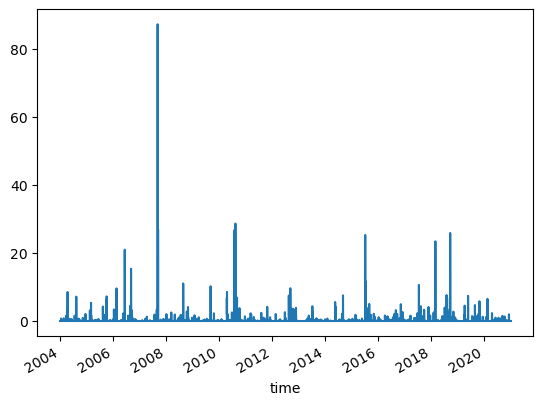

In [13]:
merged_df['precipitationCal'].plot()

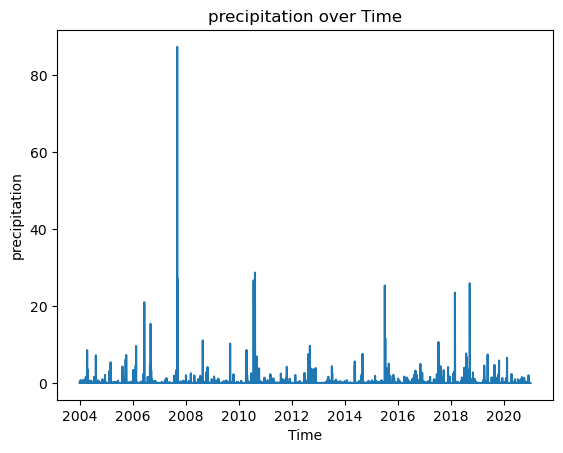

In [14]:
# Convert the index to  datetime object
merged_df.index = pd.to_datetime(merged_df.index, format='%Y%m%d%H%M%S')
# Visualize the dataset for check of stationarity
plt.plot(merged_df.index,merged_df['precipitationCal'])
plt.title('precipitation over Time')
plt.xlabel('Time')
plt.ylabel('precipitation')

plt.show()

In [15]:
#Check for null values
merged_df['precipitationCal'].isnull().sum()

0

In [16]:
merged_df['precipitationCal'].describe()

count    6206.000000
mean        0.166255
std         1.627831
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        87.348911
Name: precipitationCal, dtype: float64

In [17]:
print(merged_df['precipitationCal'].shape)

(6206,)


In [18]:
# Define the input and output variables for the model
X = []
y = []

# Iterate over each sequence in the dataset
for i in range(len(merged_df['precipitationCal']) - sequence_length - 1):
    # Extract a sequence of temperature values
    seq_temp = merged_df['precipitationCal'].values[i:i+sequence_length]
    # Define the target precipitation value
    target_temp = merged_df['precipitationCal'].values[i+sequence_length]
    
    # Append the sequence and target values to the input and output lists
    X.append(seq_temp)
    y.append(target_temp)
    
# Convert the input and output lists to numpy arrays
X = np.array(X)
y = np.array(y)

In [19]:
#Split the data into train and vali dataset
X_train,X_valid,y_train,y_valid=train_test_split(X,y,test_size=0.4, random_state=0)

print('Train set shape', X_train.shape)
print('Test set shape', X_valid.shape)

Train set shape (3705, 30)
Test set shape (2470, 30)


In [20]:
subsequences=2
timesteps = X_train.shape[1]//subsequences
X_train_sub=X_train.reshape((X_train.shape[0], subsequences, timesteps,1))
X_valid_sub=X_valid.reshape((X_valid.shape[0], subsequences, timesteps,1))

print('Train set shape', X_train_sub.shape)
print('Test set shape', X_valid_sub.shape)

Train set shape (3705, 2, 15, 1)
Test set shape (2470, 2, 15, 1)


In [21]:
epochs = 35
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)

In [345]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_sub.shape[2], X_train_sub.shape[3])))
#model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu')))
#model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu')))
#model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu')))
#model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(64, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer='adam')

print(model_cnn_lstm.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_14 (TimeDi  (None, None, 15, 64)     128       
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, None, 960)        0         
 stributed)                                                      
                                                                 
 lstm_5 (LSTM)               (None, 64)                262400    
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 262,593
Trainable params: 262,593
Non-trainable params: 0
_________________________________________________________________
None


In [346]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_sub, y_train, validation_data=(X_valid_sub, y_valid), epochs=epochs, verbose=1)

Epoch 1/35
116/116 [==============================] - 3s 11ms/step - loss: 1.6480 - val_loss: 4.1442
Epoch 2/35
116/116 [==============================] - 1s 10ms/step - loss: 1.5802 - val_loss: 4.1430
Epoch 3/35
116/116 [==============================] - 2s 17ms/step - loss: 1.4936 - val_loss: 4.1732
Epoch 4/35
116/116 [==============================] - 1s 11ms/step - loss: 1.4480 - val_loss: 4.1592
Epoch 5/35
116/116 [==============================] - 1s 11ms/step - loss: 1.4125 - val_loss: 4.2078
Epoch 6/35
116/116 [==============================] - 1s 9ms/step - loss: 1.4319 - val_loss: 4.1640
Epoch 7/35
116/116 [==============================] - 1s 10ms/step - loss: 1.3990 - val_loss: 4.1917
Epoch 8/35
116/116 [==============================] - 2s 15ms/step - loss: 1.3526 - val_loss: 4.2006
Epoch 9/35
116/116 [==============================] - 1s 12ms/step - loss: 1.3617 - val_loss: 4.2082
Epoch 10/35
116/116 [==============================] - 1s 11ms/step - loss: 1.2990 - val_los

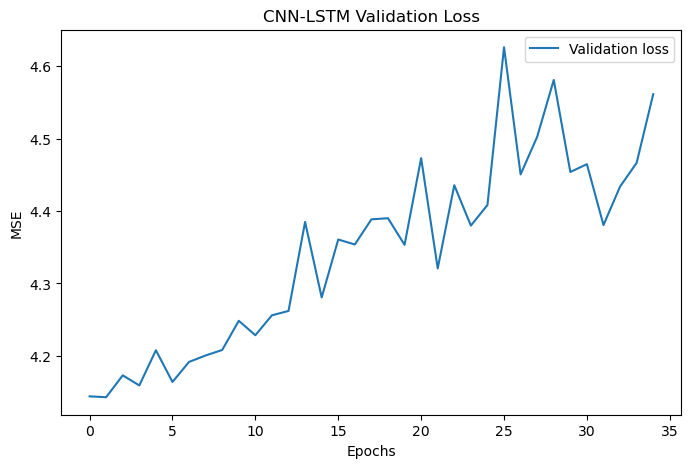

In [348]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(cnn_lstm_history.history['val_loss'], label='Validation loss')
ax.legend(loc='best')
ax.set_title('CNN-LSTM Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('MSE')

plt.show()



In [349]:
# Compute the evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_sub)
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_sub)
print('Train rmse:', np.sqrt(mean_squared_error(y_train, cnn_lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_valid, cnn_lstm_valid_pred)))

78/78 [==============================] - 0s 3ms/step
Train rmse: 0.9408845154116071
Validation rmse: 2.1357526642861537


In [379]:
print(cnn_lstm_valid_pred)

[[ 0.19634403]
 [-0.0551603 ]
 [ 0.02501841]
 ...
 [ 0.01304482]
 [-0.00987917]
 [ 0.08019878]]


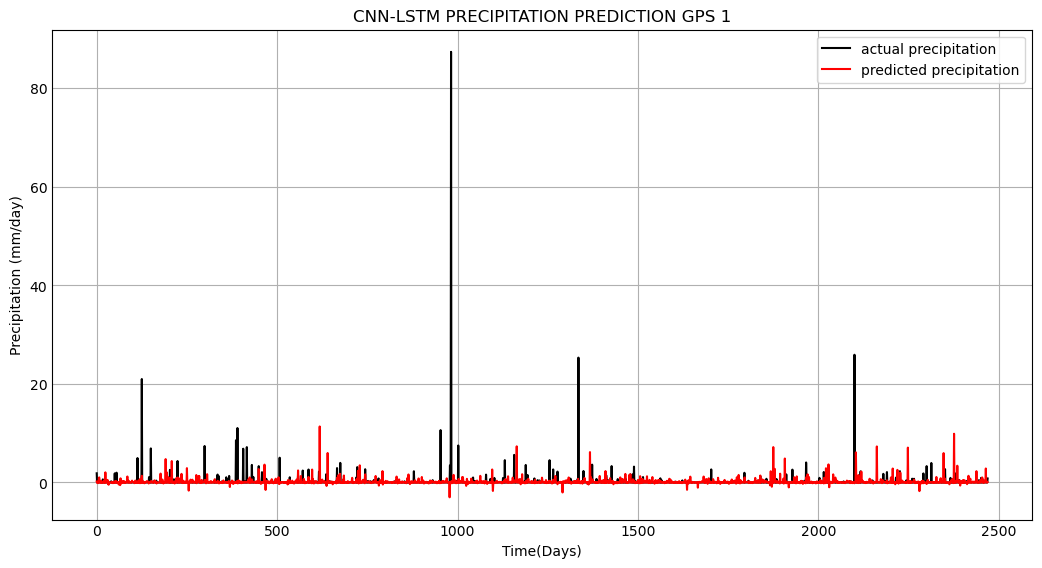

In [382]:
#Plot the comparison between actual temperature and predicted temperature
import matplotlib.pyplot as plt
      
plt.plot(y_valid ,color='black', label='actual precipitation')
plt.plot(cnn_lstm_valid_pred, color='red', label='predicted precipitation')
plt.title('CNN-LSTM PRECIPITATION PREDICTION GPS 1')
plt.xlabel('Time(Days)')
plt.ylabel('Precipitation (mm/day)')
plt.legend()
plt.show()

In [1]:
#LSTM model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, TimeDistributed
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from keras import optimizers

In [85]:
model=Sequential()
model.add(LSTM(128, input_shape =(X_train.shape[1], 1), activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(LSTM(64, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

print(model.summary())

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           131584    
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense_22 (Dense)            (None, 1)                 65        
                                                                 
Total params: 247,617
Trainable params: 247,617
Non-trainable params: 0
_________________________________________________________________
None


In [86]:
history = model.fit(X_train ,y_train, validation_data =(X_valid, y_valid), epochs =35, verbose=1)

Epoch 1/35
116/116 [==============================] - 14s 80ms/step - loss: 1.6513 - val_loss: 4.1844
Epoch 2/35
116/116 [==============================] - 11s 92ms/step - loss: 1.6347 - val_loss: 4.1835
Epoch 3/35
116/116 [==============================] - 10s 89ms/step - loss: 1.6331 - val_loss: 4.1806
Epoch 4/35
116/116 [==============================] - 9s 80ms/step - loss: 1.6281 - val_loss: 4.1789
Epoch 5/35
116/116 [==============================] - 9s 74ms/step - loss: 1.6265 - val_loss: 4.1804
Epoch 6/35
116/116 [==============================] - 9s 78ms/step - loss: 1.6411 - val_loss: 4.1762
Epoch 7/35
116/116 [==============================] - 9s 81ms/step - loss: 1.6289 - val_loss: 4.1732
Epoch 8/35
116/116 [==============================] - 11s 98ms/step - loss: 1.6264 - val_loss: 4.1765
Epoch 9/35
116/116 [==============================] - 11s 94ms/step - loss: 1.6218 - val_loss: 4.2068
Epoch 10/35
116/116 [==============================] - 11s 94ms/step - loss: 1.6259 - 

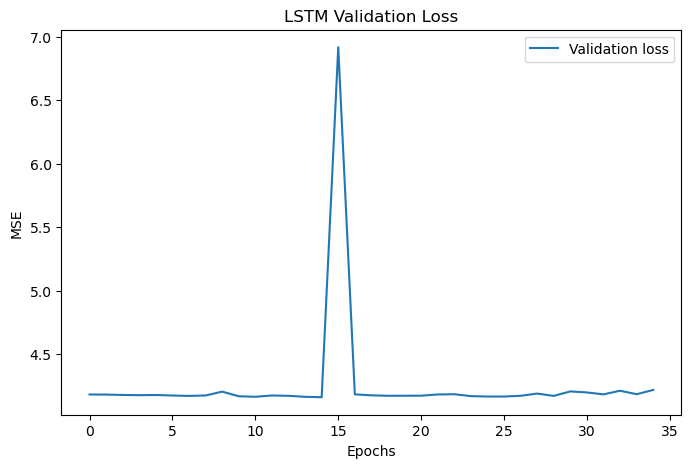

In [87]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(history.history['val_loss'], label='Validation loss')
ax.legend(loc='best')
ax.set_title('LSTM Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('MSE')

plt.show()

In [88]:
# Compute the evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
lstm_train_pred = model.predict(X_train)
lstm_valid_pred = model.predict(X_valid)
print('Train rmse:', np.sqrt(mean_squared_error(y_train, cnn_lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_valid, cnn_lstm_valid_pred)))

78/78 [==============================] - 3s 39ms/step


NameError: name 'cnn_lstm_train_pred' is not defined

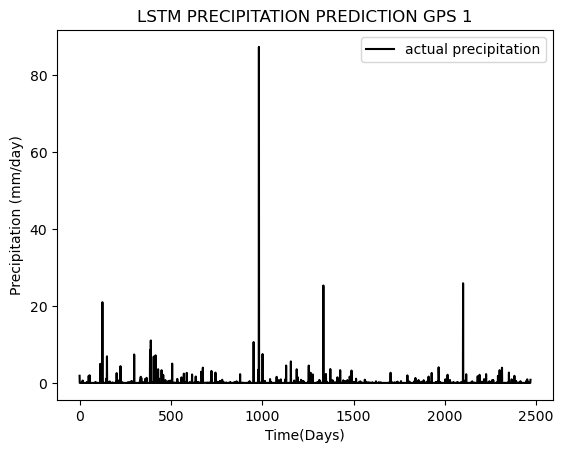

In [53]:
#Plot the comparison between actual temperature and predicted temperature
import matplotlib.pyplot as plt
      
plt.plot(y_valid ,color='black', label='actual precipitation')
#plt.plot(lstm_valid_pred, color='red', label='predicted precipitation')
plt.title('LSTM PRECIPITATION PREDICTION GPS 1')
plt.xlabel('Time(Days)')
plt.ylabel('Precipitation (mm/day)')
plt.legend()
plt.show()

In [80]:
#CNN model
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten

model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(X_train.shape[1],1)))
#model_cnn.add(Conv1D(filters=64, kernel_size=1, activation='relu',))
#model_cnn.add(Conv1D(filters=64, kernel_size=1, activation='relu',))
#model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.compile(loss='mse', optimizer='adam')

print(model_cnn.summary())


Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_40 (Conv1D)          (None, 30, 64)            128       
                                                                 
 flatten_21 (Flatten)        (None, 1920)              0         
                                                                 
 dense_21 (Dense)            (None, 128)               245888    
                                                                 
Total params: 246,016
Trainable params: 246,016
Non-trainable params: 0
_________________________________________________________________
None


In [81]:
cnn_history = model_cnn.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=epochs, verbose=1)

Epoch 1/35
116/116 [==============================] - 2s 9ms/step - loss: 1.6542 - val_loss: 4.1195
Epoch 2/35
116/116 [==============================] - 1s 7ms/step - loss: 1.6106 - val_loss: 4.1080
Epoch 3/35
116/116 [==============================] - 1s 6ms/step - loss: 1.5663 - val_loss: 4.1384
Epoch 4/35
116/116 [==============================] - 1s 7ms/step - loss: 1.5327 - val_loss: 4.1385
Epoch 5/35
116/116 [==============================] - 1s 7ms/step - loss: 1.5230 - val_loss: 4.1994
Epoch 6/35
116/116 [==============================] - 1s 6ms/step - loss: 1.5002 - val_loss: 4.1682
Epoch 7/35
116/116 [==============================] - 1s 7ms/step - loss: 1.4845 - val_loss: 4.1276
Epoch 8/35
116/116 [==============================] - 1s 6ms/step - loss: 1.4788 - val_loss: 4.1816
Epoch 9/35
116/116 [==============================] - 1s 7ms/step - loss: 1.4658 - val_loss: 4.1324
Epoch 10/35
116/116 [==============================] - 1s 6ms/step - loss: 1.4646 - val_loss: 4.1728

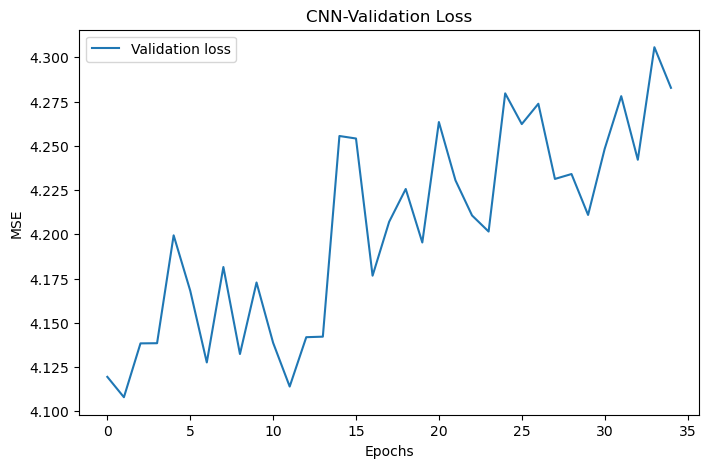

In [82]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(cnn_history.history['val_loss'], label='Validation loss')
ax.legend(loc='best')
ax.set_title('CNN-Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('MSE')

plt.show()


In [83]:
# Compute the evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
cnn_train_pred = model_cnn.predict(X_train)
cnn_valid_pred = model_cnn.predict(X_valid)
print('Train rmse:', np.sqrt(mean_squared_error(y_train, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_valid, cnn_valid_pred)))

78/78 [==============================] - 0s 2ms/step


ValueError: y_true and y_pred have different number of output (1!=128)

In [53]:
new_shape = (X_valid_sub.shape[0], 30, 1)
X_valid_sub_reshaped = np.reshape(X_valid_sub, new_shape)

In [70]:
X_train_sub_reshapedf=X_train_sub_reshaped.flatten()
X_valid_sub_reshapedf = X_valid_sub_reshaped.flatten()  

In [72]:
X_train_sub_reshapedf

array([0., 0., 0., ..., 0., 0., 0.])